In [96]:
import glob
import os
import json

import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math

from neuroformer.model_neuroformer import GPT, GPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import round_n
import gdown
set_plot_params()

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

import argparse
from neuroformer.SpikeVidUtils import round_n

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

def parse_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--infer", action="store_true", help="Inference mode")
    parser.add_argument("--train", action="store_true", default=False, help="Train mode")
    parser.add_argument("--seed", type=int, default=25, help="Random seed")
    parser.add_argument("--resume", type=str, default=None, help="Resume from checkpoint")
    parser.add_argument("--rand_perm", action="store_true", default=False, help="Randomly permute the ID column")
    parser.add_argument("--mconf", type=str, default=None, help="Path to model config file")
    parser.add_argument("--downstream", action="store_true", default=False, help="Downstream task")
    parser.add_argument("--freeze_model", action="store_true", default=False, help="Freeze model")
    parser.add_argument("--title", type=str, default=None)
    parser.add_argument("--dataset", type=str, default="Combo3_V1AL")
    parser.add_argument("--behavior", action="store_true", default=False, help="Behavior task")
    parser.add_argument("--pred_behavior", action="store_true", default=False, help="Predict behavior")
    parser.add_argument("--past_state", action="store_true", default=False, help="Input past state")
    parser.add_argument("--visual", action="store_true", default=False, help="Visualize")
    parser.add_argument("--contrastive", action="store_true", default=False, help="Contrastive")
    parser.add_argument("--clip_loss", action="store_true", default=False, help="Clip loss")
    parser.add_argument("--class_weights", action="store_true", default=False, help="Class weights")
    return parser.parse_args()


# if __name__ == "__main__":
#     args = parse_args()
#     INFERENCE = not args.train
# else:'
#     INFERENCE = True

# check if jupyter notebook
try:
    shell = get_ipython().__class__.__name__
    print("Running in Jupyter notebook")
    INFERENCE = True
    SEED = 25
    DOWNSTREAM = False
    RESUME = "./models/tensorboard/Combo3_V1AL/pretrain/mlp/freeze_False/randperm_False/Big_fixed_noself-att_2/sparse_f:None_id:None/w:0.05_wp:0.25/Cont:False_window:0.05_f_window:0.25_df:0.01_blocksize:55_conv_True_shuffle:True_batch:128_sparse_(None_None)_blocksz110_pos_emb:False_temp_emb:True_drop:0.1_dt:True_2.0_27_max0.01_(8, 8, 8)_8_256/_epoch_140.pt"
    RAND_PERM = False
    MCONF = "./models/tensorboard/Combo3_V1AL/pretrain/mlp/freeze_False/randperm_False/Big_fixed_noself-att_2/sparse_f:None_id:None/w:0.05_wp:0.25/mconf.yaml"
    FREEZE_MODEL = False
    TITLE = None
    DATASET = "Combo3_V1AL"
    BEHAVIOR = False
    PREDICT_BEHAVIOR = False
    VISUAL = True
    PAST_STATE = True
    CONTRASTIVE = False
    CLIP_LOSS = False
    CLASS_WEIGHTS = False
except:
    print("Running in terminal")
    args = parse_args()
    INFERENCE = not args.train
    SEED = args.seed
    DOWNSTREAM = args.downstream
    RESUME = args.resume
    RAND_PERM = args.rand_perm
    MCONF = args.mconf
    FREEZE_MODEL = args.freeze_model
    DATASET = args.dataset
    BEHAVIOR = args.behavior
    PREDICT_BEHAVIOR = args.pred_behavior
    VISUAL = args.visual
    PAST_STATE = args.past_state
    CONTRASTIVE = args.contrastive
    CLIP_LOSS = args.clip_loss
    CLASS_WEIGHTS = args.class_weights

# SET SEED - VERY IMPORTANT
set_seed(SEED)

print(f"CONTRASTIUVEEEEEEE {CONTRASTIVE}")
print(f"VISUAL: {VISUAL}")
print(f"PAST_STATE: {PAST_STATE}")



Running in Jupyter notebook
CONTRASTIUVEEEEEEE False
VISUAL: True
PAST_STATE: True


In [97]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""

if DATASET == "Combo3_V1AL":
    RESPONSE_PATH = "./data/Combo3_V1AL/Combo3_V1AL_response.csv"
    STIMULUS_PATH = "./data/Combo3_V1AL/Combo3_V1AL_stimulus.pt"

if not os.path.exists(RESPONSE_PATH):
    print("Downloading data...")
    url = "https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=share_link"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output=os.path.dirname(RESPONSE_PATH))
else:
    from neuroformer.prepare_data import DataLinks
    DataLinkDS = getattr(DataLinks, DATASET)
    url = DataLinkDS['url']
    RESPONSE_PATH = DataLinkDS['RESPONSE_PATH']
    STIMULUS_PATH = DataLinkDS['STIMULUS_PATH']
    # gdown.download_folder(id=url)


df = pd.read_csv(RESPONSE_PATH)
video_stack = torch.load(STIMULUS_PATH)
stimulus = video_stack[:, :, 0]


torch.Size([3, 640, 1, 64, 112])


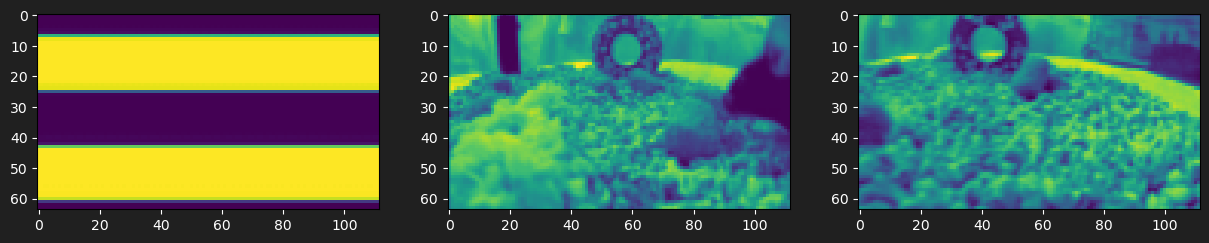

In [98]:
print(video_stack.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(video_stack[i, 1, 0].permute(0, 1))




In [99]:
# load config files
import yaml

# base_path = "configs/visnav/predict_behavior"
if MCONF is not None:
    base_path = os.path.dirname(MCONF)
elif RESUME is not None:
    base_path = os.path.dirname(RESUME)
else:
    base_path = "./models/tensorboard/V1_AL/downstream/learnt_temporal_embeddings/sparse_f:None_id:None/w:0.05_wp:0.25"
    

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)


In [117]:

if INFERENCE:
    frame_window = mconf.frame_window
    window = mconf.window
    window_prev = mconf.window_prev
    window_behavior = mconf.window_behavior if hasattr(mconf, 'window_behavior') else None
    dt = mconf.dt
    dt_frames = mconf.dt_frames if hasattr(mconf, 'dt_frames') else 0.05
    dt_vars = mconf.dt_vars if hasattr(mconf, 'dt_vars') else 0.05
    dt_speed = mconf.dt_speed if hasattr(mconf, 'dt_speed') else 0.2
    intervals = None
else:
    window = 0.05
    window_prev = 0.25
    frame_window = window + window_prev
    window_behavior = window
    dt = 0.01
    dt_frames = 0.05
    dt_vars = 0.05
    dt_speed = 0.2
    intervals = None

# randomly permute 'id' column
if RAND_PERM:
    df['ID'] = df['ID'].sample(frac=1, random_state=25).reset_index(drop=True)



In [118]:
## choose modalities ##

# behavior
behavior = BEHAVIOR
behavior_vars = ['eyerad', 'phi', 'speed', 'th']
# behavior_vars = ['speed']
n_behavior = len(behavior_vars)
predict_behavior = PREDICT_BEHAVIOR
# stimulus
visual_stim = VISUAL



In [119]:
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals


if behavior is True:
    behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
    # rename t to time
    behavior = behavior.rename(columns={'t': 'Time'}) if behavior is not None else None
    behavior['Interval'] = make_intervals(behavior, window)
    behavior['Interval_2'] = make_intervals(behavior, window_prev)

    # prepare speed variables
    behavior['speed'] = behavior['speed'].apply(lambda x: round_n(x, dt_speed))
    dt_range_speed = behavior['speed'].min(), behavior['speed'].max()
    dt_range_speed = np.arange(dt_range_speed[0], dt_range_speed[1] + dt_speed, dt_speed)
    n_behavior = len(dt_range_speed)

    stoi_speed = { round_n(ch, dt_speed):i for i,ch in enumerate(dt_range_speed) }
    itos_speed = { i:round_n(ch, dt_speed) for i,ch in enumerate(dt_range_speed) }
    assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
    samples_per_behavior = int((window + window_prev) // dt_vars)
    behavior_block_size = int((window + window_prev) // dt_vars) * (len(behavior.columns) - 1)
else:
    behavior = None
    behavior_vars = None
    behavior_block_size = 0
    samples_per_behavior = 0
    stoi_speed = None
    itos_speed = None
    dt_range_speed = None
    n_behavior = None

if predict_behavior:
    loss_bprop = ['behavior']
else:
    loss_bprop = None




In [120]:
from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

# randomly permute 'id' column
if RAND_PERM:
    print('// randomly permuting ID column //')
    df['ID'] = df['ID'].sample(frac=1, random_state=25).reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']




In [121]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
# kernel_size = (n_frames, 4, 4)
kernel_size = [n_frames, 8, 8]
stride_size = [n_frames, 4, 4]
padding_size = 0
n_embd = 256
n_embd_frames = 64
frame_feats = stimulus
frame_block_size = 0
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

prev_id_block_size = 55
id_block_size = 55   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }



/tmp/ipykernel_14855/4070223165.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame_feats = torch.tensor(stimulus, dtype=torch.float32)


In [122]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]

# r_split_ft = np.arange(0, 1, 0.25)
r_split_ft = 0.1
finetune_trials = train_trials[:int(len(train_trials) * r_split_ft)]
finetune_data = df[df['Trial'].isin(finetune_trials)]

n = []
n_trial = [2, 8, 14, 19]
for n_stim in range(df['Trial'].max() // 20):
    # n_trial = [2, 4, 6, 8, 10, 12, 14, 18]
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t)
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)


In [123]:
if CLASS_WEIGHTS:
    class_weights = {}
    class_weights['id'] = torch.ones(len(stoi.keys()), dtype=torch.float32)
    class_weights['id'][stoi['PAD']] = 0
    class_weights['id'][stoi['EOS']] = 1 / 10
    class_weights['dt'] = torch.ones(len(stoi_dt.keys()), dtype=torch.float32)
    class_weights['dt'][stoi_dt['PAD']] = 0
else:
    class_weights = None


In [130]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset=DATASET,
                                  behavior=behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed, labels=True)

if INFERENCE:
    update_object(train_dataset, dconf)

train_dataset = train_dataset.copy(train_data)
test_dataset = train_dataset.copy(test_data)
finetune_dataset = train_dataset.copy(finetune_data)
    
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')


Population Size:  389
ID Population Size:  389
DT Population Size:  28
train: 20316, test: 5334


In [131]:

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 200
batch_size = round((32 * 2))
shuffle = True

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        pretrain=False,
                        n_state_layers=8, n_state_history_layers=8,
                        n_stimulus_layers=8, self_att_layers=0,
                        n_behavior_layers=0, predict_behavior=predict_behavior, n_behavior=n_behavior,
                        n_head=4, n_embd=n_embd, 
                        contrastive=mconf.contrastive, clip_emb=1024, clip_temp=mconf.clip_temp,
                        conv_layer=conv_layer, kernel_size=kernel_size, stride_size=stride_size, padding_size=padding_size,
                        temp_emb=mconf.temp_emb, pos_emb=False,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'],
                        class_weights=class_weights)  # 0.35

if INFERENCE or MCONF is not None:
    update_object(model_conf, mconf)

if not INFERENCE:
    if PAST_STATE is False:
        print(f"// -- No past state, layers=0 -- //")
        model_conf.n_state_history_layers = 0

    if CONTRASTIVE or CLIP_LOSS is True:
        print(f"// -- contrastive objective clip{CLIP_LOSS} -- //")
        model_conf.contrastive = True
        model_conf.clip_loss = CLIP_LOSS
    else:
        print(f"// -- no contrastive objective -- //")
        model_conf.contrastive = False
    if VISUAL is False:
        print(f"// -- No visual, layers=0 -- //")
        model_conf.n_stimulus_layers = 0

model = GPT(model_conf)

if RESUME is not None:
    # update_object(model_conf, mconf)
    print(f"// -- Loading model from {RESUME} -- //")
    model.load_state_dict(torch.load(RESUME), strict=False)
    if not DOWNSTREAM:
        model_path = f"{RESUME[:-3]}_resume.pt"


# epoch250_rand{RAND_PERM}_downstream:{DOWNSTREAM}
# title =  f'3/4prop_{CLASS_WEIGHTS}/past_state_{PAST_STATE}_visual{VISUAL}_contrastive_{CONTRASTIVE}_clip_loss{CLIP_LOSS}t{mconf.clip_temp}_freeze_{FREEZE_MODEL}_class_weights{CLASS_WEIGHTS}/randperm_{RAND_PERM}/Big_fixed_noself-att'
title = f"epoch{max_epochs}_seed{SEED}rand{RAND_PERM}_/downstream:{DOWNSTREAM}"
if INFERENCE:
    model_path = glob.glob(os.path.join(base_path, '**.pt'), recursive=True)[0]
else:
    # model_path = f"""./models/tensorboard/{DATASET}/ablations_small/{title}_2/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{mconf.window}_wp:{mconf.window_prev}/Cont:{mconf.contrastive}_window:{mconf.window}_f_window:{mconf.frame_window}_df:{mconf.dt}_blocksize:{mconf.id_block_size}_conv_{mconf.conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""
    model_path = f"""./models/tensorboard/{DATASET}/pretrain/downstream_exp/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{mconf.window}_wp:{mconf.window_prev}/Cont:{mconf.contrastive}_window:{mconf.window}_f_window:{mconf.frame_window}_df:{mconf.dt}_blocksize:{mconf.id_block_size}_conv_{mconf.conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""


05/03/2023 20:26:14 - INFO - neuroformer.model_neuroformer -   number of parameters: 3.196698e+07


256 28
// -- Loading model from ./models/tensorboard/Combo3_V1AL/pretrain/mlp/freeze_False/randperm_False/Big_fixed_noself-att_2/sparse_f:None_id:None/w:0.05_wp:0.25/Cont:False_window:0.05_f_window:0.25_df:0.01_blocksize:55_conv_True_shuffle:True_batch:128_sparse_(None_None)_blocksz110_pos_emb:False_temp_emb:True_drop:0.1_dt:True_2.0_27_max0.01_(8, 8, 8)_8_256/_epoch_140.pt -- //


In [132]:

if DOWNSTREAM:
    print(f"// Downstream Objective: {DOWNSTREAM} //")
    """
    image indexes

    (140, 260)
    (339, 424)
    (500, 620)
    (680, 840) 
    (960, 1050)

    """
    import tifffile
    from neuroformer.SpikeVidUtils import get_interval_idx
    from neuroformer.modules import ClassifierWrapper

    stim2_path = "./data/Combo3_V1AL/stimuli/Combined Stimuli 3-Movie2.tif"
    stimulus_2 = tifffile.imread(stim2_path)

    stim3_path = "./data/Combo3_V1AL/stimuli/Combined Stimuli 3-Movie3.tif"
    stimulus_3 = tifffile.imread(stim3_path)

    mouse_indexes = [(140, 260), (339, 424), (500, 620), (680, 840), (960, 1050)]
    stimulus_mice = np.concatenate([stimulus_2[i[0]:i[1]] for i in mouse_indexes])
    stimulus_control = np.concatenate([stimulus_3[i[0]:i[1]] for i in mouse_indexes])
    assert stimulus_mice.shape == stimulus_control.shape, "stimulus shapes must be equal"

    control_labels = np.zeros(stimulus_control.shape[0])
    mice_labels = np.ones(stimulus_mice.shape[0])
    stimulus_task = np.concatenate([stimulus_control, stimulus_mice])
    labels_task = np.concatenate([control_labels, mice_labels])
    mouse_indexes_downsampled = [tuple(map(lambda x: x // 3, i)) for i in mouse_indexes]
    stim_2_ds = stimulus[1]
    stim_2_ds_mice = np.concatenate([stim_2_ds[i[0]:i[1]] for i in mouse_indexes_downsampled])
    mouse_indexes_intervals = [tuple(map(lambda x: get_interval_idx(x, 0.05), i)) for i in mouse_indexes_downsampled]
    intervals_cls = np.concatenate([np.arange(i[0], i[1], window) for i in mouse_indexes_intervals])
    # don't use same intervals for training and testing (because images will be the same)
    train_interval_cls = np.random.choice(intervals_cls, size=int(len(intervals_cls) * 0.8), replace=False)
    test_interval_cls = np.setdiff1d(intervals_cls, train_interval_cls)
    train_trial_cls = train_data[train_data['Trial'] > 20]['Trial'].unique()
    test_trial_cls = test_data[test_data['Trial'] > 20]['Trial'].unique()
    train_interval_trial_cls = np.array(np.meshgrid(train_interval_cls, train_trial_cls)).T.reshape(-1, 2)
    test_interval_trial_cls = np.array(np.meshgrid(test_interval_cls, test_trial_cls)).T.reshape(-1, 2)
    train_dataset = train_dataset.copy(train_data, t=train_interval_trial_cls)
    test_dataset = test_dataset.copy(test_data, t=test_interval_trial_cls)

In [133]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e4, 
                    decay_weights=True, weight_decay=0.1, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=20, loss_bprop=loss_bprop)

if not INFERENCE:
    if DOWNSTREAM:
        mconf.__setattr__('freeze_model', FREEZE_MODEL)
        tconf.__setattr__('warmup_tokens', 100)
        N_CLASSES = 2
        classifier = ClassifierWrapper(model, mconf, N_CLASSES)
        train_model = classifier

    else:
        train_model = model
    trainer = Trainer(train_model, train_dataset, test_dataset, tconf, model_conf)
    trainer.train()
else:
    model_path = glob.glob(os.path.join(base_path, '**.pt'), recursive=True)[0]
    if RESUME is None:
        print(f"Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path), strict=False)
    else:
        print(f"Loading model from {RESUME}")
        model.load_state_dict(torch.load(RESUME), strict=False)
    


Loading model from ./models/tensorboard/Combo3_V1AL/pretrain/mlp/freeze_False/randperm_False/Big_fixed_noself-att_2/sparse_f:None_id:None/w:0.05_wp:0.25/Cont:False_window:0.05_f_window:0.25_df:0.01_blocksize:55_conv_True_shuffle:True_batch:128_sparse_(None_None)_blocksz110_pos_emb:False_temp_emb:True_drop:0.1_dt:True_2.0_27_max0.01_(8, 8, 8)_8_256/_epoch_140.pt


In [134]:
loader = DataLoader(train_dataset, batch_size=10, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)

In [135]:
x, y = next(iterable)

In [136]:
arr1 = torch.rand(4, 350)
arr2 = torch.rand(3, 350)

torch.cat([arr1, arr2], dim=0).shape

torch.Size([7, 350])

In [137]:
preds, features, loss = model(x,y)

In [138]:
preds['probs_id'].shape

torch.Size([31, 389])

In [ ]:
from utils import all_device
from tqdm import tqdm

def collect_preds(model, loader, n_iter, device="cpu"):
    preds = []
    features = []
    pbar = tqdm(enumerate(loader), total=n_iter)
    for i, (x, y) in pbar:
        if i > n_iter:
            break
        x = all_device(x, device)
        y = all_device(y, device)
        with torch.no_grad():
            pred, feature, loss = model(x, y)
            preds.append(pred['probs_id'])
            features.append(feature)
    preds = torch.cat(preds, dim=0)
    return preds

preds = collect_preds(model, loader, n_iter=100, device="cpu")

preds_mean = preds.mean(dim=0)
preds_std = preds.std(dim=0)

# plot the mean and std of the predictions
plt.plot(preds_mean)
plt.fill_between(np.arange(preds_mean.shape[0]), preds_mean - preds_std, preds_mean + preds_std, alpha=0.5)
plt.grid()
plt.scatter(389, 0.0025)

plt.savefig(os.path.join(base_path, 'preds_mean_std.png'))
np.save(os.path.join(base_path, 'preds_mean.npy'), preds_mean)

In [ ]:
# model.eval()
# # model.train()
# for i in range(1):
#     x, y = next(iterable)
#     x_1 = x['id'][0].detach().cpu().numpy()
#     x_pad = x['pad']
#     x_1 = x['id'][:len(x_1) - int(x_pad[0])]
#     preds, features, loss = model(x, y)

#     step_choices = random.sample(range(len(x_1)), min(5, len(x_1)))
#     fig, ax = plt.subplots(1, len(step_choices), figsize=(50, 5))
#     for step in step_choices:
#         step_preds = preds['id'][0, step].detach().cpu().numpy()
#         x_axis = np.arange(0, len(step_preds))
#         ax_step = ax[step]
#         ax_step.scatter(x_axis, step_preds)
#         ax_step.set_title(f"""{step}""", fontsize=20)


In [ ]:
x, y = next(iterable)
for k in x.keys():
    print(k, x[k].shape)



In [ ]:
from neuroformer.utils import predict_raster_recursive_time_auto, process_predictions

PARALLEL = True
df_pred_path = None

results_dict = dict()
df_pred = None if df_pred_path is None else pd.read_csv(df_pred_path)
df_true = None

top_p = 0.75
top_p_t = 0.9
temp = 1.3
temp_t = 1.

trials = sorted(train_data['Trial'].unique())[::4]

if df_pred_path is None:
    from joblib import Parallel, delayed
    # Define a function to process each trial
    def process_trial(model, train_dataset, df, stoi, itos_dt, itos, window, window_prev, top_p, top_p_t, temp, temp_t, trial):
        print(f"-- No. {n} Trial: {trial} --")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = train_dataset.copy(df_trial)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                        sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                        frame_end=0, get_dt=True, gpu=False, pred_dt=True, plot_probs=False)
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        return df_trial_pred, df_trial_true

    if PARALLEL:
        # Process each trial in parallel
        results = Parallel(n_jobs=-1)(delayed(process_trial)(model, train_dataset, df, stoi, itos_dt, 
                                                            itos, window, window_prev, top_p, top_p_t, 
                                                            temp, temp_t, trial) for trial in trials)
    else:
        # Process each trial sequentially
        results = []
        for trial in trials:
            results.append(process_trial(model, train_dataset, df, stoi, itos_dt, 
                                            itos, window, window_prev, top_p, top_p_t, 
                                            temp, temp_t, trial))
    # Combine the results from each trial
    for n, (df_trial_pred, df_trial_true) in enumerate(results):   
        print(f"-- No. {n} Trial --")
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])

from neuroformer.analysis import compute_scores
df_true = df[df['Trial'].isin(trials)]
scores = compute_scores(df_true, df_pred)
print(scores)
print(f"ID unique: pred: {len(df_pred['ID'].unique())}, true: {len(df_true['ID'].unique())}")
print(f"len pred: {len(df_pred)}, len true: {len(df_true)}")

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)
df_pred.to_csv(os.path.join(dir_name, F'df_pred_.csv'))



In [ ]:
"""

Split data into full-stimulus trials

"""
# dir_name = os.path.dirname(model_path)
# df_pred = pd.read_csv(os.path.join(dir_name, F'df_pred_.csv'))

from neuroformer.analysis import get_rates_trial, calc_corr_psth, get_accuracy, compute_scores
from neuroformer.SpikeVidUtils import create_full_trial, set_intervals


t_1, t_2 = 35, 36
trial_data_1 = df[df['Trial'] == t_1]
trial_dataset_1 = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
trial_loader_1 = DataLoader(trial_dataset_1, shuffle=False, pin_memory=False)

def loader_trial(df, n_trial):
    trial_data = df[df['Trial'] == n_trial]
    trial_dataset = SpikeTimeVidData2(trial_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
    trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
    return trial_loader

trial_data_1 = loader_trial(df, t_1)
trial_data_2 = loader_trial(df, t_2)

iterable1 = iter(trial_data_1)
iterable2 = iter(trial_data_2)

n_1 = test_data['Trial'].unique()
n_2 = test_data['Trial'].unique() + 1

df_pred_full = create_full_trial(df_pred)
df_1 = create_full_trial(df, trials)
df_2 = create_full_trial(df, n_1)
df_3 = create_full_trial(df, n_2)

# sort by interval, trial
window_pred = 0.5
min_window = window_prev + window
df_pred_full = set_intervals(df_pred_full, window, window_prev, window_pred)
df_1 = set_intervals(df_1, window, window_prev, window_pred)
df_2 = set_intervals(df_2, window, window_prev, window_pred)
df_3 = set_intervals(df_3, window, window_prev, window_pred)

window_pred = window if window_pred is None else window_pred
# intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
intervals = np.array(sorted(set(df_pred_full['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

neurons = df['ID'].unique()
top_corr_pred = calc_corr_psth(rates_pred, rates_1, neurons=neurons)
top_corr_real = calc_corr_psth(rates_1, rates_2, neurons=neurons)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3, neurons=neurons)



In [ ]:
"""

Evaluate results

"""


from neuroformer.visualize import set_plot_white, plot_distribution

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")
# save scores to json

score_dict = {'true': scores, 'pred': pred_scores}
n_score_paths = len(glob.glob(os.path.join(dir_name, F'scores*.json')))
with open(os.path.join(dir_name, F'scores_{n}_top:{top_p}_{temp}_{top_p_t}_{temp_t}.json'), 'w') as f:
    json.dump(score_dict, f)

# dir_name = os.path.dirname(model_path)
save_dir = os.path.dirname(model_path)
df_pred.to_csv(os.path.join(save_dir, F'df_pred.csv'))

set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) bin {window_pred}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6)
plt.legend(fontsize=20)
plt.savefig(os.path.join(dir_name, F'psth_corr.svg'))
plt.show()

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

# # %%
# loader = DataLoader(test_dataset, shuffle=False, pin_memory=False)
# iterable = iter(test_dataset)



# # %%
# var_group = 'Interval'
# int_trials = df.groupby([var_group, 'Trial']).size()
# print(int_trials.mean())
# # df.groupby(['Interval', 'Trial']).agg(['nunique'])
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# # df.groupby(['Interval_2', 'Trial']).size().mean()



# # %%
# # while iv < 1.95:
# x, y = next(iterable)

# T = len(x['id'])
# P = x['pad']
# T_prev = len(x['id_prev'])
# P_prev = x['pad_prev'] - 4

# T_y = len(y['id'])
# P_y = x['pad']

# iv = float(x['interval'])

# xid = x['id'][: T - P]
# xid = [itos[int(i)] for i in xid]
# xdt = x['dt'][: T - P]

# yid = y['id'][: T_y - P_y]
# yid = [itos[int(i)] for i in yid]
# ydt = y['dt'][: T - P]

# xid_prev = x['id_prev'][: T_prev - P_prev]
# xid_prev = [itos[int(i)] for i in xid_prev]

# print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
# print(f"x: {xid}")
# print(f"xdt: {xdt}")
# print(f"y: {yid}")
# print(f"ydt: {ydt}")

# print(f"xid_prev: {xid_prev}")

# tdiff = 0
# t_var = 'Time' # 'Interval'
# int_var = 'cid'
# # df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# # df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

# # t_var = 'Time' # 'Interval'
# # int_var = 'pid'
# # df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))

# # print(f"trial: {x['trial']}, pid: {x['pid']}, cid: {x['cid']}")

# # plt.imshow(x['frames'][0, 0])

# # %%
# itos_dt


# # %%
# loader = DataLoader(test_dataset, shuffle=True, pin_memory=False)
# iterable = iter(loader)


# # %%
# x, y = next(iterable)
# preds, features, loss = model(x, y





In [ ]:
iterable = iter(train_dataset)

In [ ]:
# while x['trial'] < 4:

x, y = next(iterable)

T = len(x['id'])
P = x['pad'] - 1
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")
print(f"xid_prev: {xid_prev}")

if 'behavior' in y or x:
    xy_behavior = y['behavior'] if 'behavior' in y else x['behavior']
    t_var = 'Interval' # 'Interval'
    tdiff = 0
    int_var = 'cid'
    # xy_behavior = [itos_speed[int(i)] for i in xy_behavior]
    print(f"y_behavior: {xy_behavior}")
    # print(f"true_behavior: {true_behavior}")

tdiff = 0
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

t_var = 'Time' # 'Interval'
int_var = 'cid'
df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))]